In [19]:
import os  
os.environ["CUDA_VISIBLE_DEVICES"]='3'
import torch
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
random.seed(10)
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
import sys
sys.path.append('../')
from utils import *
from utils.model_utils import eval_model
from utils.model_utils import train_model
%matplotlib inline

In [20]:
from utils.drift_detection import drift_detection
from utils.k_means import kmeans
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import chi2_contingency, ks_2samp, entropy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from utils.oodscores import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [21]:
# from MALCOM import calculate_log as callog
# from MALCOM import data_utils
# from MALCOM import detectors
# import MALCOM.detectors.detect_utils as detect_utils
# from MALCOM import malcom

In [22]:
torch.cuda.manual_seed(0)

# ImageNet-C

In [23]:
imagebase = '/local/rcs/ll3504/datasets/'

In [24]:
#Create Dataset from ImageFolder, transforms applied
def get_dataset(path='/database', dataset_name = '', transform = 'test' ,tag_with_drift = False, tag = 1):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }
    dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms[transform])#only use test for now
    
    if tag_with_drift:
        dataset.samples = [(d, tag) for d, s in dataset.samples]

    return dataset

In [25]:
def mixed_imagenetc(imagebase, datasplit ,level= 5,  batch_size=128, num_workers=24, tag_with_drift = False,drop_last= True):
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    
    dataset_name = 'imagenetc/val'
    imagenet_data = get_dataset(imagebase, dataset_name, tag_with_drift = tag_with_drift, tag = 0)
    split = [ datasplit[0][0] + datasplit[0][1], 50000 - (datasplit[0][0] + datasplit[0][1]) ]
    split = [ datasplit[0][0] + datasplit[0][1], 50000 - (datasplit[0][0] + datasplit[0][1]) ]
    tmp_data, _ = torch.utils.data.random_split(imagenet_data, split , generator=torch.Generator().manual_seed(10))
    ref_data, val_data = torch.utils.data.random_split(tmp_data, [datasplit[0][0],datasplit[0][1]]
                                                         , generator=torch.Generator().manual_seed(10))
    ref_dataloader = torch.utils.data.DataLoader(ref_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=num_workers,drop_last=drop_last)
    
    val_dataloader = torch.utils.data.DataLoader(val_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=num_workers,drop_last=drop_last)
    corrupted_datasets= []
    
    for i in range(len(corruption)):
        dataset_name = 'imagenetc/' + corruption[i] + '/' + str(level)
        corr_test_images = get_dataset(imagebase, dataset_name, tag_with_drift = tag_with_drift, tag = 1)
            
        split = [ datasplit[i+1][0] + datasplit[i+1][1], 50000 - (datasplit[i+1][0] + datasplit[i+1][1]) ]
        tmp_data, _ = torch.utils.data.random_split(corr_test_images,split, generator=torch.Generator().manual_seed(10))
        
        _, val_data = torch.utils.data.random_split(tmp_data, [datasplit[i+1][0],datasplit[i+1][1]], 
                                                    generator=torch.Generator().manual_seed(10))
        corrupted_datasets.append(val_data)
        
    corrupted_datasets = torch.utils.data.ConcatDataset(corrupted_datasets)
    return ref_dataloader, val_dataloader, corrupted_datasets, corruption

In [26]:
batch_size = 1

In [40]:
datasplit = [(1000,49000)] + [(0,50000) for i in range(16)]
ref_dl, val_dl, corrupted_ds, _ = mixed_imagenetc(imagebase, datasplit, 3, tag_with_drift = False, batch_size=batch_size)
corrupted_dl = torch.utils.data.DataLoader(corrupted_ds,shuffle=False,batch_size = batch_size , num_workers=48,drop_last= True)

In [5]:
ref_logist = torch.load('./ref_logists.pt')
iid_logist = torch.load('./1_iid_logists.pt')
ood_logist = torch.load('./1_ood_logists.pt')

# Model

In [31]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# or any of these variants
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /home/wei.hao/.cache/torch/hub/pytorch_vision_v0.10.0


# ROC

In [114]:
def mixed_imagenetc(imagebase, datasplit ,level= 5,  batch_size=128, num_workers=24, tag_with_drift = False,drop_last= True):
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    
    dataset_name = 'imagenetc/val'
    imagenet_data = get_dataset(imagebase, dataset_name, tag_with_drift = tag_with_drift, tag = 0)
    split = [ datasplit[0][0] + datasplit[0][1], 50000 - (datasplit[0][0] + datasplit[0][1]) ]
    tmp_data, _ = torch.utils.data.random_split(imagenet_data, split , generator=torch.Generator().manual_seed(10))
    ref_data, val_data = torch.utils.data.random_split(tmp_data, [datasplit[0][0],datasplit[0][1]]
                                                         , generator=torch.Generator().manual_seed(10))
    ref_dataloader = torch.utils.data.DataLoader(ref_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=num_workers,drop_last=drop_last)
    corrupted_datasets= [val_data]
    
    for i in range(len(corruption)):
        dataset_name = 'imagenetc/' + corruption[i] + '/' + str(level)
        corr_test_images = get_dataset(imagebase, dataset_name, tag_with_drift = tag_with_drift, tag = 1)
        
        split = [ datasplit[i+1][0] + datasplit[i+1][1], 50000 - (datasplit[i+1][0] + datasplit[i+1][1]) ]
        tmp_data, _ = torch.utils.data.random_split(corr_test_images,split, generator=torch.Generator().manual_seed(10))
        
        _, val_data = torch.utils.data.random_split(tmp_data, [datasplit[i+1][0],datasplit[i+1][1]], 
                                                    generator=torch.Generator().manual_seed(10))
        corrupted_datasets.append(val_data)
        
    corrupted_datasets = torch.utils.data.ConcatDataset(corrupted_datasets)
    return ref_dataloader, corrupted_datasets, ['no_corruption'] + corruption

In [115]:
ref_dl, corrupted_ds, _ = mixed_imagenetc(imagebase, datasplit, 3, tag_with_drift = True)

In [116]:
# calclulate the ref_logists
flag = True
ref_logist = 0
for inputs, labels in ref_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs).cpu()
    torch.cuda.empty_cache()
    if flag:
        ref_logist = outputs
        flag = False
    else:
        ref_logist = torch.cat((ref_logist,outputs),0)

In [117]:
## FNR = 1 - TPR,  we want this low , we want TPR high, which makes FPR@TPR95 a good metric and we want this low

In [118]:
def confusion_matrix(dataloader, model, drift_detector, device):
    labels = []
    predicts = []
    for inputs, y in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs).cpu()
        torch.cuda.empty_cache()
        result = drift_detector.get_result(outputs)
        labels += y.tolist()
        predicts += [result['is_drift']] * len(y)
    
    t_p = sum([1 if (predicts[i] == 1 and  labels[i] == 1) else 0 for i in range( len(labels))]  )
    f_p = sum([1 if (predicts[i] == 1 and  labels[i] == 0) else 0 for i in range( len(labels))]  )
    f_n = sum([1 if (predicts[i] == 0 and  labels[i] == 1) else 0 for i in range( len(labels))]  )
    t_n = sum([1 if (predicts[i] == 0 and  labels[i] == 0) else 0 for i in range( len(labels))]  )
        
    return t_p, f_p, f_n, t_n

In [ ]:
batch_sizes = [1,2,4,8,16,32,64,128,256,512]
# Compute ROC curve and ROC area for each class
fpr = []
tpr = []
roc_auc = []
for batch_size in tqdm(batch_sizes):
    full_loader = torch.utils.data.DataLoader(corrupted_ds,shuffle=False,batch_size=batch_size, num_workers=48,drop_last= True)
    t_p, f_p, f_n, t_n = confusion_matrix(full_loader, model, detector, device)
    fpr.append(f_p/ (f_p + t_n))
    tpr.append(t_p/(t_p + f_n))
    print(tpr, fpr)
    torch.cuda.empty_cache()

In [13]:
tpr = [0.28087875, 0.3115575, 0.449695, 0.64821, 0.8000980009800098, 0.8703187031870319, 0.903595179758988, 0.9252702851370678, 0.9606348825347295,0.9846380029403823]
fpr = [0.05871428571428571, 0.050489795918367344, 0.04669387755102041, 0.04897959183673469, 0.04914285714285714, 0.04, 0.04130612244897959, 0.030857142857142857, 0.03346938775510204,0.01779591836734694]

In [145]:
def confusion_matrix(iid_logist, ood_logist, detector,batch_size):
    labels = []
    predicts = []
    for j in range(len(iid_logist)//batch_size):
        result = detector.get_result(np.squeeze(iid_logist[j*batch_size:(j + 1)*batch_size], axis=1))
        labels += [0 for i in range(batch_size)]
        predicts += [result['is_drift'] for i in range(batch_size)]
        
    for j in range(len(ood_logist)//batch_size):
        result = detector.get_result(np.squeeze(ood_logist[j*batch_size:(j + 1)*batch_size], axis=1))
        labels += [1 for i in range(batch_size)]
        predicts += [result['is_drift'] for i in range(batch_size)]
    
    t_p = sum([1 if (predicts[i] == 1 and  labels[i] == 1) else 0 for i in range( len(labels))]  )
    f_p = sum([1 if (predicts[i] == 1 and  labels[i] == 0) else 0 for i in range( len(labels))]  )
    f_n = sum([1 if (predicts[i] == 0 and  labels[i] == 1) else 0 for i in range( len(labels))]  )
    t_n = sum([1 if (predicts[i] == 0 and  labels[i] == 0) else 0 for i in range( len(labels))]  )
        
    return t_p, f_p, f_n, t_n

In [144]:
detector = drift_detection(ref_logist, 0.05, method='KSDrift',indicator = 'energy')

In [147]:
batch_sizes = [1,2,4,8,16,32,64,128,256,512]
# Compute ROC curve and ROC area for each class
fpr = []
tpr = []
roc_auc = []
for batch_size in tqdm(batch_sizes):
    t_p, f_p, f_n, t_n = confusion_matrix(iid_logist, ood_logist, detector, batch_size)
    fpr.append(f_p/ (f_p + t_n))
    tpr.append(t_p/(t_p + f_n))
    print(tpr, fpr)
    torch.cuda.empty_cache()

 10%|█         | 1/10 [08:54<1:20:10, 534.47s/it]

[0.32144125] [0.05679591836734694]


 20%|██        | 2/10 [13:13<49:41, 372.66s/it]  

[0.32144125, 0.363825] [0.05679591836734694, 0.057102040816326534]


 30%|███       | 3/10 [15:44<31:37, 271.11s/it]

[0.32144125, 0.363825, 0.52451] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837]


 40%|████      | 4/10 [17:09<19:45, 197.64s/it]

[0.32144125, 0.363825, 0.52451, 0.70359] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449]


 50%|█████     | 5/10 [17:55<11:55, 143.01s/it]

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078]


 60%|██████    | 6/10 [18:21<06:53, 103.42s/it]

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915]


 70%|███████   | 7/10 [18:40<03:47, 75.82s/it] 

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032, 0.91312] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915, 0.048366013071895426]


 80%|████████  | 8/10 [18:53<01:51, 55.73s/it]

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032, 0.91312, 0.9424] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915, 0.048366013071895426, 0.04712041884816754]


 90%|█████████ | 9/10 [19:00<00:40, 40.45s/it]

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032, 0.91312, 0.9424, 0.97888] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915, 0.048366013071895426, 0.04712041884816754, 0.03664921465968586]


100%|██████████| 10/10 [19:05<00:00, 114.54s/it]

[0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032, 0.91312, 0.9424, 0.97888, 0.9942381562099872] [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915, 0.048366013071895426, 0.04712041884816754, 0.03664921465968586, 0.0]


In [171]:
fpr = [0.05679591836734694, 0.057102040816326534, 0.04922448979591837, 0.04963265306122449, 0.04866100587851078, 0.04768125408229915, 0.048366013071895426, 0.04712041884816754, 0.03664921465968586, 0.0]
tpr = [0.32144125, 0.363825, 0.52451, 0.70359, 0.82774, 0.88032, 0.91312, 0.9424, 0.97888, 0.9942381562099872]

In [183]:
batch_sizes = [1,2,4,8,16,32,64,128,256,512]

In [185]:
fpr_tpr = sorted(zip(fpr, tpr,batch_sizes), key=lambda x: x[0])
fpr, tpr,batch_sizes = [list(tup) for tup in zip(*fpr_tpr)]
#roc_auc = auc(fpr, tpr)

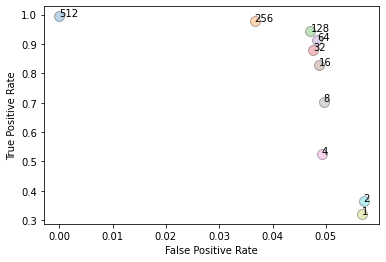

In [192]:
import matplotlib.pyplot as plt

y = tpr
x = fpr
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

fig, ax = plt.subplots()
#plt.scatter(x, y)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
for i, txt in enumerate(batch_sizes):
    ax.scatter(x[i], y[i], c=colors[i],alpha=0.3, s = 100,edgecolors='black')
    plt.annotate(txt, (x[i], y[i]))
plt.show()

# Threshold method

In [44]:
import torch.nn.functional as F
from tqdm import tqdm
import json
concat = lambda x: np.concatenate(x, axis=0)

In [37]:
indicators = ['uncertainty','MSP','energy']

In [16]:
def ood_score(x, score, temperature = 1.):
    # positives (ood) have higher scores
    if score == 'MSP':
        return -softmax(x, axis=-1).max(axis=-1)[0]
    elif score == 'OE':
        return x.mean(-1) - logsumexp(x, axis=-1)
    elif score == 'energy':
        return - temperature*logsumexp(x/temperature, axis=-1)

    return entropy(softmax(x, axis=-1), axis=-1)

In [46]:
th_fpr_tprs = {}
th_roc_aucs = {}
for i in range(len(indicators)):
    inscore = []
    outscore = []
    for logist in iid_logist:
        inscore.append(ood_score(logist, indicators[i], temperature = 1.))
    for logist in ood_logist:
        outscore.append(ood_score(logist, indicators[i], temperature = 1.))
    
    inscore = concat(inscore)
    outscore = concat(outscore)
    
    print(show_performance(outscore, inscore, method_name=indicators[i]))
    pos = np.array(outscore[:]).reshape((-1, 1))
    neg = np.array(inscore[:]).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] += 1
    fpr, tpr, _ = roc_curve(labels, examples)
    th_fpr_tprs[indicators[i]] = (fpr, tpr) 
    th_roc_aucs[indicators[i]] = auc(fpr, tpr)

			uncertainty
FPR95:			80.28
AUROC:			75.70
AUPR:			97.99
None
			MSP
FPR95:			80.58
AUROC:			73.74
AUPR:			97.73
None
			energy
FPR95:			78.45
AUROC:			77.86
AUPR:			98.22
None


In [91]:
for k in th_fpr_tprs:
    th_fpr_tprs[k] = (th_fpr_tprs[k][0].tolist(),th_fpr_tprs[k][1].tolist())
with open('th_fpr_tprs.json', 'w') as fp:
    json.dump(th_fpr_tprs, fp)

In [48]:
with open('th_fpr_tprs.json', 'r') as fp:
    th_fpr_tprs = json.load(fp)

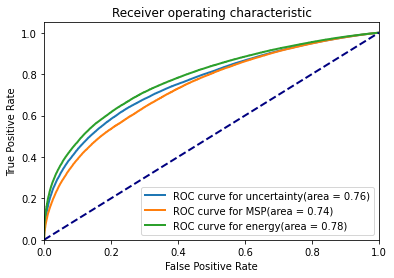

In [49]:
plt.figure()
lw = 2
for i in indicators:
    plt.plot(
        th_fpr_tprs[i][0],th_fpr_tprs[i][1],
        lw=lw,
        label="ROC curve for " + i + "(area = %0.2f)" % th_roc_aucs[i],
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# KS

In [112]:
batch_size = 128
fpr_tprs = {}
roc_aucs = {}
for i in range(len(indicators)):
    detector = drift_detection(ref_logist, 0.05, method='KSDrift',indicator = indicators[i], temperature = 1.)
    inscore = []
    outscore = []
    for j in range(len(iid_logist)//batch_size):
        result = detector.get_result(np.squeeze(iid_logist[j*batch_size:(j + 1)*batch_size], axis=1))
        inscore += [result['p_val'] for j in range(batch_size)]
        
    for j in range(len(ood_logist)//batch_size):
        result = detector.get_result(np.squeeze(ood_logist[j*batch_size:(j + 1)*batch_size], axis=1))
        outscore += [result['p_val'] for j in range(batch_size)]
        
    print(show_performance([-1*j for j in outscore], [-1*j for j in inscore], 
                           method_name=indicators[i] + ' KStest(batchsize) = ' + str(batch_size)))
    
    pos = -1*np.array(outscore).reshape((-1, 1))
    neg = -1*np.array(inscore).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] += 1
    fpr, tpr, _ = roc_curve(labels, examples)
    fpr_tprs[indicators[i]] = (fpr, tpr) 
    roc_aucs[indicators[i]] = auc(fpr, tpr)
    print("fpr at tpr@92%: ")
    print(fpr_and_fdr_at_recall(labels, examples, 0.92))

			uncertainty KStest(batchsize) = 128
FPR95:			11.26
AUROC:			98.00
AUPR:			99.88
None
fpr at tpr@92%: 
0.020942408376963352
			MSP KStest(batchsize) = 128
FPR95:			13.35
AUROC:			97.88
AUPR:			99.87
None
fpr at tpr@92%: 
0.028795811518324606
			energy KStest(batchsize) = 128
FPR95:			7.33
AUROC:			98.42
AUPR:			99.90
None
fpr at tpr@92%: 
0.007853403141361256


In [89]:
for k in fpr_tprs:
    fpr_tprs[k] = (fpr_tprs[k][0].tolist(),fpr_tprs[k][1].tolist())
with open('fpr_tprs.json', 'w') as fp:
    json.dump(fpr_tprs, fp)

In [90]:
with open('fpr_tprs.json', 'r') as fp:
    fpr_tprs = json.load(fp)

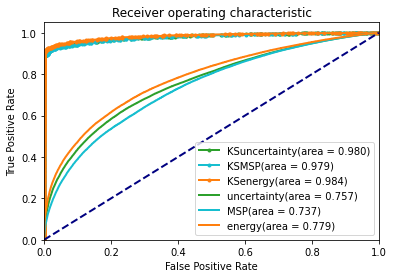

In [195]:
plt.figure()
ax = plt.gca()
ax.set_prop_cycle(color=['tab:green', 'tab:cyan', 'tab:orange'] )
lw = 2
for i in indicators:
    plt.plot(
        fpr_tprs[i][0],fpr_tprs[i][1],
        lw=lw,
        label="KS" + i + "(area = %0.3f)" % roc_aucs[i],marker= '.',
    )
    
for i in indicators:
    plt.plot(
        th_fpr_tprs[i][0],th_fpr_tprs[i][1],
        lw=lw,
        label=i + "(area = %0.3f)" % th_roc_aucs[i],
    )
    
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Time consumption

In [35]:
import time
import json

In [36]:
indicators = ['uncertainty','MSP','energy']
batch_sizes = [1,2,4,8,16,32,64,128,256,512]

In [8]:
def ood_uncertain(x):
    return entropy(softmax(x, axis=-1), axis=-1)

def ood_MSP(x):
    return -softmax(x, axis=-1).max(axis=-1)[0]

def ood_OE(x):
    return x.mean(-1) - logsumexp(x, axis=-1)

def ood_energy(x, temperature = 1.):
    return - temperature*logsumexp(x/temperature, axis=-1)

def ood_func(score):
    if score == 'MSP':
        return ood_MSP
    elif score == 'OE':
        return ood_OE
    elif score == 'energy':
        return ood_energy

    return ood_uncertain

In [9]:
ks_total_time = {}

for i in tqdm(range(len(indicators))):
    
    detector = drift_detection(ref_logist, 0.05, method='KSDrift',indicator = indicators[i], temperature = 1.)
    ks_total_time[indicators[i]] = []
    
    for j in range(len(batch_sizes)):
        
        batch_size = batch_sizes[j]
        ks_total_time[indicators[i]].append(0)
            
        for k in range(len(iid_logist)//batch_size):
            logist = np.squeeze(iid_logist[k*batch_size:(k + 1)*batch_size], axis=1)
            start = time.time()
            #Exclude data transfer time
            result = detector.get_result(logist)['is_drift']
            
            ks_total_time[indicators[i]][j] += (time.time() - start)
        
        for k in range(len(ood_logist)//batch_size):
            logist = np.squeeze(ood_logist[k*batch_size:(k + 1)*batch_size], axis=1)
            start = time.time()
            #Exclude data transfer time
            result = detector.get_result(logist)['is_drift']
            
            ks_total_time[indicators[i]][j] += (time.time() - start)
            
        
        num_img = (len(iid_logist)//batch_size + len(ood_logist)//batch_size)*batch_size
    
        ks_total_time[indicators[i]][j] = ks_total_time[indicators[i]][j] * 1000000/num_img

100%|██████████| 3/3 [1:15:56<00:00, 1518.98s/it]


In [10]:
th_total_time = {}
for i in tqdm(range(len(indicators))):
    
    th_total_time[indicators[i]] = []
    oodscore = ood_func(indicators[i])
    
    for j in range(len(batch_sizes)):
        
        batch_size = batch_sizes[j]
        th_total_time[indicators[i]].append(0)

        for k in range(len(iid_logist)//batch_size):
            logist = np.squeeze(iid_logist[k*batch_size:(k + 1)*batch_size], axis=1)
            
            start = time.time()
            #Exclude data transfer time
            score = oodscore(logist)
            
            th_total_time[indicators[i]][j] += (time.time() - start)
        
        for k in range(len(ood_logist)//batch_size):
            logist = np.squeeze(ood_logist[k*batch_size:(k + 1)*batch_size], axis=1)
            
            start = time.time()
            #Exclude data transfer time
            score = oodscore(logist)
            
            th_total_time[indicators[i]][j] +=  (time.time() - start)
            
        
        num_img = (len(iid_logist)//batch_size + len(ood_logist)//batch_size)*batch_size
        
        th_total_time[indicators[i]][j] = th_total_time[indicators[i]][j]*1000000/num_img

100%|██████████| 3/3 [21:26<00:00, 428.75s/it]


In [15]:
with open("ks_time.json", "w") as outfile:
    json.dump(ks_total_time, outfile)

In [16]:
with open("th_time.json", "w") as outfile:
    json.dump(th_total_time, outfile)

In [49]:
with open("th_time.json", "r") as outfile:
    th_total_time = json.load(outfile)
    
with open("ks_time.json", "r") as outfile:
    ks_total_time = json.load(outfile)

In [38]:
t = 0
# calclulate the ref_logists
for inputs, labels in ref_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        start = time.time()
        outputs = outputs.cpu()
        t += (time.time() - start)
    torch.cuda.empty_cache()
t = t*(1000000/len(ref_dl))

In [45]:
t

41.63622856140137

In [54]:
for i in indicators:
    ks_total_time[i] = [t + j for j in ks_total_time[i]]
    th_total_time[i] = [t + j for j in th_total_time[i]]

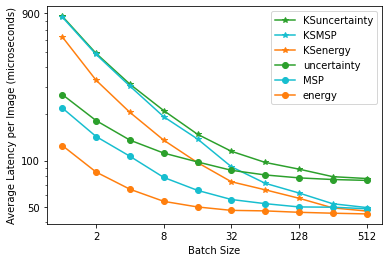

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


x = [1,2,4,8,16,32,64,128,256,512]

ax = plt.gca()
ax.set_prop_cycle(color=['tab:green', 'tab:cyan', 'tab:orange'] )
ax.set_xscale('log', base=2)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_yscale('log', base=10)
ax.set_yticks([50,100,900])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())



for i in indicators:
    plt.plot(x, ks_total_time[i], '-*', label="KS" + i)
    
for i in indicators:
    plt.plot(x, th_total_time[i], '-o', label=i)

plt.legend(loc="upper right")
plt.xlabel("Batch Size")
plt.ylabel("Average Latency per Image (microseconds)")
plt.show()

In [31]:
#Data transfer time excluded - lets try to include and measure`